In [15]:
import pandas as pd
# Import necessary libraries
from ortools.linear_solver import pywraplp
import numpy as np
from solvers.ortools_solver import solve_vehicle_routing_problem
from utils.visualisation import visualize_routes
import random
import matplotlib.pyplot as plt



In [16]:

"""
Solves the Vehicle Routing Problem with pre-assigned hubs using Google OR-Tools.

Parameters:
- N: List of nodes (customers and hubs)
- C: List of customers
- H: List of hubs
- K: List of vehicle types
- demand: Dictionary with customer demands {customer: demand}
- vehicle_capacity: Dictionary with vehicle capacities {vehicle_type: capacity}
- vehicle_max_distance: Dictionary with maximum distances {vehicle_type: max_distance}
- vehicle_available: Dictionary with number of available vehicles {vehicle_type: count}
- distance: Dictionary with distances {(i, j): distance}
- cost: Dictionary with costs {(i, j, k): cost}
- M: Big M value for constraints (default: 1e5)

Returns:
- A dictionary with the optimal objective value, hubs used, customer assignments, and vehicle routes.
"""


'\nSolves the Vehicle Routing Problem with pre-assigned hubs using Google OR-Tools.\n\nParameters:\n- N: List of nodes (customers and hubs)\n- C: List of customers\n- H: List of hubs\n- K: List of vehicle types\n- demand: Dictionary with customer demands {customer: demand}\n- vehicle_capacity: Dictionary with vehicle capacities {vehicle_type: capacity}\n- vehicle_max_distance: Dictionary with maximum distances {vehicle_type: max_distance}\n- vehicle_available: Dictionary with number of available vehicles {vehicle_type: count}\n- distance: Dictionary with distances {(i, j): distance}\n- cost: Dictionary with costs {(i, j, k): cost}\n- M: Big M value for constraints (default: 1e5)\n\nReturns:\n- A dictionary with the optimal objective value, hubs used, customer assignments, and vehicle routes.\n'

In [21]:


# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Nodes
customers = [f'Customer{i}' for i in range(1, 16)]
hubs = [f'Hub{i}' for i in range(1, 4)]
nodes = customers + hubs

num_nodes = len(nodes)
num_customers = len(customers)
num_hubs = len(hubs)

# Coordinates for nodes (x, y)
coordinates = {}
for node in nodes:
    x = np.random.uniform(0, 100)
    y = np.random.uniform(0, 100)
    coordinates[node] = (x, y)

# Calculate distance matrix
distance_matrix = np.zeros((num_nodes, num_nodes))
for i, node_i in enumerate(nodes):
    x_i, y_i = coordinates[node_i]
    for j, node_j in enumerate(nodes):
        x_j, y_j = coordinates[node_j]
        distance = np.hypot(x_j - x_i, y_j - y_i)
        distance_matrix[i][j] = distance

# Demands for customers
demands = [random.randint(10, 30) for _ in range(num_customers)]

# Vehicle types
vehicle_types = ['Truck', 'Van']
num_vehicle_types = len(vehicle_types)
vehicle_capacity = [100, 50]  # Corresponds to Truck and Van
vehicle_max_distance = [500, 300]
vehicle_available = [5, 10]

# Cost matrix (same as distance for simplicity)
cost_matrix = np.zeros((num_nodes, num_nodes, num_vehicle_types))
for k in range(num_vehicle_types):
    cost_matrix[:, :, k] = distance_matrix * 1  # Assuming unit cost per distance unit

# Define the lists of nodes
N = nodes
C = customers
H = hubs
K = vehicle_types

# Solve the problem
results = solve_vehicle_routing_problem(
    N, C, H, K, demands, vehicle_capacity,
    vehicle_max_distance, vehicle_available,
    distance_matrix, cost_matrix, coordinates
)

# Visualize the results
if results:
    visualize_routes(results)
    # Optionally, print the results
    print("\nOptimal Objective Value:", results['Optimal Objective Value'])

    print("\nHubs Used:")
    for h in results['Hubs Used']:
        print(f"Hub at {h}")

    print("\nCustomer Assignments:")
    for c, h in results['Customer Assignments'].items():
        print(f"Customer {c} assigned to Hub {h}")

    print("\nVehicle Routes:")
    for vehicle_type in K:
        print(f"\nVehicle Type {vehicle_type} Routes:")
        for route in results['Vehicle Routes'][vehicle_type]:
            print(f"{route['from']} -> {route['to']} with load {route['load']:.2f} and distance {route['distance']:.2f}")
else:
    print("No feasible solution found.")


Best Solution: ([0, 1, 0], [0, 2, 2, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 1])
Best Cost: 1288.754057954869


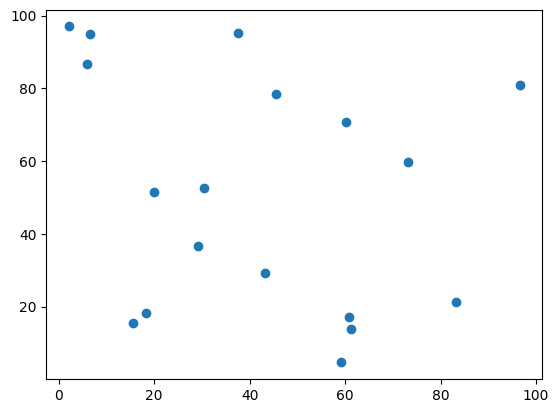

In [20]:
plt.scatter([x[0] for x in coordinates.values()], [x[1] for x in coordinates.values()])

In [22]:
# VRP Tour Assignment Problem using Google OR-Tools

# Import necessary libraries
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# Define the data
# Customers and hubs
customers = ['C1', 'C2', 'C3', 'C4']
hubs = ['H1', 'H2']

# Cost matrix c_{ih}: Cost of assigning customer i to hub h
# Rows correspond to customers, columns correspond to hubs
cost_matrix = [
    [10, 15],  # Costs for C1
    [20, 12],  # Costs for C2
    [18, 25],  # Costs for C3
    [30, 20]   # Costs for C4
]

# Customer assignments from the hub assignment problem
customer_assignments = {
    'C1': 'H1',
    'C2': 'H2',
    'C3': 'H1',
    'C4': 'H2'
}

# Create a full distance matrix between all customers and hubs
nodes = customers + hubs
num_nodes = len(nodes)

# For illustration, define symmetric distances using the cost matrix and arbitrary values
import random
random.seed(42)

# Generate distances between all pairs of nodes
distance_matrix_full = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]
for i in range(num_nodes):
    for j in range(i, num_nodes):
        if nodes[i] in customers and nodes[j] in customers:
            # Distance between customers (random value between 5 and 15)
            distance = random.randint(5, 15)
        elif nodes[i] in customers or nodes[j] in customers:
            # Distance between customer and hub (from cost matrix)
            if nodes[i] in customers:
                ci = customers.index(nodes[i])
                hi = hubs.index(nodes[j]) if nodes[j] in hubs else -1
            else:
                ci = customers.index(nodes[j])
                hi = hubs.index(nodes[i]) if nodes[i] in hubs else -1
            distance = cost_matrix[ci][hi]
        else:
            # Distance between hubs (arbitrary large value)
            distance = 100
        distance_matrix_full[i][j] = distance
        distance_matrix_full[j][i] = distance  # Symmetric

# Function to solve VRP for each hub
def solve_vrp_for_hub(hub, assigned_customers):
    print(f"\nRoute for {hub}:")

    if not assigned_customers:
        print(f"No customers assigned to {hub}.")
        return

    # Create a list of nodes for this hub (customers + hub)
    hub_nodes = assigned_customers + [hub]
    hub_node_indices = [nodes.index(node) for node in hub_nodes]

    # Create distance matrix for this hub
    distance_matrix = []
    for i in hub_node_indices:
        row = []
        for j in hub_node_indices:
            row.append(distance_matrix_full[i][j])
        distance_matrix.append(row)

    # VRP parameters
    num_locations = len(distance_matrix)
    depot = num_locations - 1  # Hub is the depot

    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(num_locations, 1, depot)

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    def distance_callback(from_index, to_index):
        # Returns the distance between the two nodes
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution
    if solution:
        index = routing.Start(0)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(hub_nodes[node_index])
            index = solution.Value(routing.NextVar(index))
        route.append(hub_nodes[manager.IndexToNode(index)])  # Add the depot at the end
        print(" -> ".join(route))
    else:
        print("No solution found for this hub.")

# Solve VRP for each hub
for hub in hubs:
    assigned_customers = [customer for customer, assigned_hub in customer_assignments.items() if assigned_hub == hub]
    solve_vrp_for_hub(hub, assigned_customers)



Route for H1:
H1 -> C1 -> C3 -> H1

Route for H2:
H2 -> C2 -> C4 -> H2


In [23]:
# VRP Tour Assignment Problem using Google OR-Tools with Demands and Vehicle Capacity Constraints

# Import necessary libraries
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import random

# Seed for reproducibility
random.seed(42)

# 1. Define the data
# Customers and hubs
num_customers = 20
num_hubs = 4

customers = [f'C{i+1}' for i in range(num_customers)]
hubs = [f'H{i+1}' for i in range(num_hubs)]
nodes = customers + hubs

# Assign demands to each customer (random integer between 1 and 10)
customer_demands = {customer: random.randint(1, 10) for customer in customers}

# Define vehicle capacities (assuming all vehicles have the same capacity)
vehicle_capacity = 15  # Adjust as needed

# Assume one vehicle per hub for simplicity
vehicles_per_hub = 2  # Number of vehicles per hub
total_vehicles = vehicles_per_hub * num_hubs

# Vehicle data: List of capacities (one entry per vehicle)
vehicle_capacities = [vehicle_capacity] * total_vehicles

# Map vehicles to hubs
vehicles_to_hubs = {}
vehicle_index = 0
for hub in hubs:
    for _ in range(vehicles_per_hub):
        vehicles_to_hubs[vehicle_index] = hub
        vehicle_index += 1

# 2. Create the full distance matrix between all customers and hubs
num_nodes = len(nodes)

# Generate random coordinates for nodes (for distance calculation)
node_coordinates = {}
for node in nodes:
    x = random.uniform(0, 100)
    y = random.uniform(0, 100)
    node_coordinates[node] = (x, y)

# Calculate Euclidean distances between nodes
distance_matrix_full = []
for i in range(num_nodes):
    row = []
    node_i = nodes[i]
    x_i, y_i = node_coordinates[node_i]
    for j in range(num_nodes):
        node_j = nodes[j]
        x_j, y_j = node_coordinates[node_j]
        distance = int(((x_i - x_j)**2 + (y_i - y_j)**2)**0.5)
        row.append(distance)
    distance_matrix_full.append(row)

# 3. Customer assignments to hubs (for simplicity, assign customers to the nearest hub)
customer_assignments = {}
for customer in customers:
    min_distance = float('inf')
    assigned_hub = None
    customer_idx = nodes.index(customer)
    for hub in hubs:
        hub_idx = nodes.index(hub)
        distance = distance_matrix_full[customer_idx][hub_idx]
        if distance < min_distance:
            min_distance = distance
            assigned_hub = hub
    customer_assignments[customer] = assigned_hub

# 4. Function to solve VRP for each hub with capacity constraints
def solve_vrp_for_hub(hub, assigned_customers, vehicles, vehicle_capacities):
    print(f"\nRoutes for {hub}:")

    if not assigned_customers:
        print(f"No customers assigned to {hub}.")
        return

    # Create a list of nodes for this hub (customers + hub)
    hub_nodes = assigned_customers + [hub]
    hub_node_indices = [nodes.index(node) for node in hub_nodes]

    # Create distance matrix for this hub
    distance_matrix = []
    for i in hub_node_indices:
        row = []
        for j in hub_node_indices:
            row.append(distance_matrix_full[i][j])
        distance_matrix.append(row)

    # Demands for this hub's customers
    demands = []
    for node_index in hub_node_indices:
        node = nodes[node_index]
        if node in customer_demands:
            demands.append(customer_demands[node])
        else:
            demands.append(0)  # Hub has zero demand

    # VRP parameters
    num_locations = len(distance_matrix)
    num_vehicles = len(vehicles)
    depot = num_locations - 1  # Hub is the depot

    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback
    def distance_callback(from_index, to_index):
        # Returns the distance between the two nodes
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add capacity constraint
    def demand_callback(from_index):
        # Returns the demand of the node
        from_node = manager.IndexToNode(from_index)
        return demands[from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        vehicle_capacities,  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution
    if solution:
        for vehicle_id in range(num_vehicles):
            index = routing.Start(vehicle_id)
            route = []
            load = 0
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                node_name = hub_nodes[node_index]
                route.append(node_name)
                load += demands[node_index]
                index = solution.Value(routing.NextVar(index))
            route.append(hub)  # End at the hub
            if len(route) > 2:
                print(f"Vehicle {vehicles[vehicle_id]} Route: {' -> '.join(route)} | Load: {load}")
    else:
        print("No solution found for this hub.")

# 5. Solve VRP for each hub
for hub in hubs:
    assigned_customers = [customer for customer, assigned_hub in customer_assignments.items() if assigned_hub == hub]
    # Get vehicles assigned to this hub
    vehicles = [vehicle_id for vehicle_id, vehicle_hub in vehicles_to_hubs.items() if vehicle_hub == hub]
    vehicle_caps = [vehicle_capacities[vehicle_id] for vehicle_id in vehicles]
    solve_vrp_for_hub(hub, assigned_customers, vehicles, vehicle_caps)



Routes for H1:
Vehicle 0 Route: H1 -> C11 -> H1 | Load: 7
Vehicle 1 Route: H1 -> C10 -> H1 | Load: 10

Routes for H2:
Vehicle 2 Route: H2 -> C7 -> C16 -> C17 -> H2 | Load: 15
Vehicle 3 Route: H2 -> C2 -> C19 -> C20 -> C15 -> H2 | Load: 15

Routes for H3:
Vehicle 5 Route: H3 -> C5 -> H3 | Load: 4

Routes for H4:
No solution found for this hub.
